## Outlier Detection & Removal

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count, avg, sum, date_format
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
# Start Spark Session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/10/03 01:53:14 WARN Utils: Your hostname, nadya-aurelia.local resolves to a loopback address: 127.0.0.1; using 192.168.0.103 instead (on interface en0)
22/10/03 01:53:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/03 01:53:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# reading the datasets
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")
transactions = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")

In [4]:
# rename columns in merchants and consumer df
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [5]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [6]:
df_trx.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)



---
### Aggregated Transaction Dataframe before cleaning

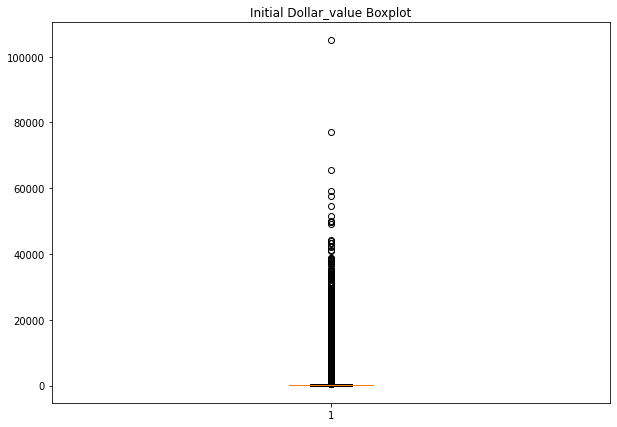

In [7]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot((df_trx.toPandas())['dollar_value'])
plt.title("Initial Dollar_value Boxplot")
plt.show()

In [8]:
df_trx.count()

3494038

---
### Outlier Removal 

In [9]:
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

Remove entries with take rate of less than 35.

In [10]:
df_trx = df_trx.withColumn("tags", normalize_tags(F.col("tags")))
df_trx = df_trx.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))
df_trx = df_trx.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("take_rate", F.col("take_rate").astype(FloatType()))
df_trx = df_trx.withColumn("categories", clean_string(F.col("categories")))
df_trx = df_trx.where(F.col("dollar_value") >= 35)

In [11]:
df_trx.count()

2341671

Remove entries with null values.

In [12]:
df_trx = df_trx.na.drop("any")
df_trx.count()

2341671

Remove entries with out of range dates.

In [13]:
df_trx = df_trx.drop(F.col('order_datetime').between('2021-02-28', '2021-08-27'))
df_trx.count()

2341671

Use Inter-Quartile Range (IQR) proximity rule to remove outliers due to the skewed distribution of the initial dataset. Data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers, where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

Outlier Removal (all)

In [18]:
def remove_outlier_IQR(df):
    """ Function to implement IQR method
    Args : 
    - df : dataframe to implement IQR outlier removal method
    Returns :
    - df_final : output dataframee after outlier removal
    """
    Q1=df['dollar_value'].quantile(0.25)
    Q3=df['dollar_value'].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df['dollar_value']<(Q1-1.5*IQR)) | (df['dollar_value']>(Q3+1.5*IQR)))]
    return df_final

In [19]:
temp_df = df_trx.toPandas()
df_outlier_removed = remove_outlier_IQR(temp_df)

In [20]:
df_outlier_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099404 entries, 0 to 2341670
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   merchant_abn    int64  
 1   user_id         int64  
 2   consumer_id     object 
 3   consumer_name   object 
 4   address         object 
 5   state           object 
 6   postcode        object 
 7   gender          object 
 8   dollar_value    float64
 9   order_id        object 
 10  order_datetime  object 
 11  merchant_name   object 
 12  tags            object 
 13  categories      object 
 14  revenue_level   object 
 15  take_rate       float32
dtypes: float32(1), float64(1), int64(2), object(12)
memory usage: 264.3+ MB


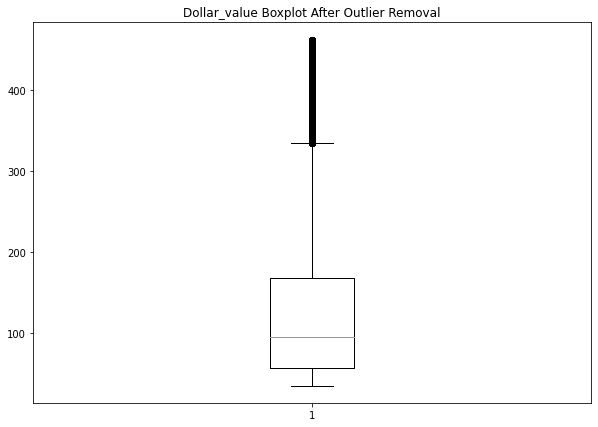

In [21]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df_outlier_removed['dollar_value'])
plt.title("Dollar_value Boxplot After Outlier Removal")
plt.show()

Outlier Removal (by tags)

In [25]:
def remove_outlier_tags_IQR(df):
    """ Function to implement IQR method
    Args : 
    - df : dataframe to implement IQR outlier removal method
    Returns :
    - df_final : output dataframee after outlier removal
    """

    df_final = pd.DataFrame()   # Initialize empty dataframe
    categories = df.select("categories").distinct().collect()

    for category in categories:
        category = category["categories"]
        category_df = df.where(F.col("categories") == category)
        category_df = category_df.toPandas()

        # Show Initial Dollar Value Boxplot per category
        fig = plt.figure(figsize =(10, 7))
        plt.boxplot(category_df['dollar_value'])
        plt.title(category)
        plt.show()  

        # Calculate IQR per category to Remove Outliers
        Q1=category_df['dollar_value'].quantile(0.25)
        Q3=category_df['dollar_value'].quantile(0.75)
        IQR=Q3-Q1
        category_df_final=category_df[~((category_df['dollar_value']<(Q1-1.5*IQR)) | (category_df['dollar_value']>(Q3+1.5*IQR)))]

        # Show Dollar Value Boxplot per category after Outlier Removal
        fig = plt.figure(figsize =(10, 7))
        plt.boxplot(category_df_final['dollar_value'])
        plt.title(category)
        plt.show() 

        df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe

    return df_final

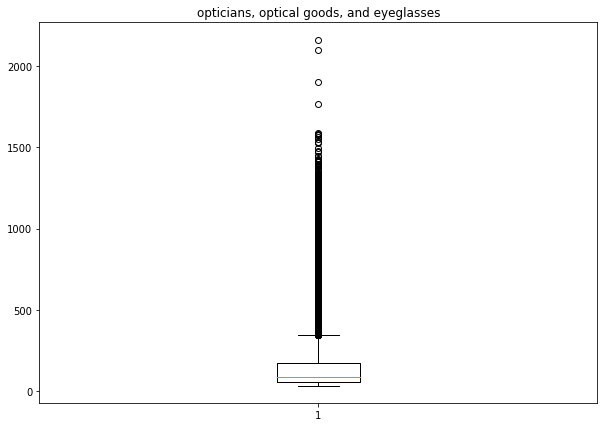

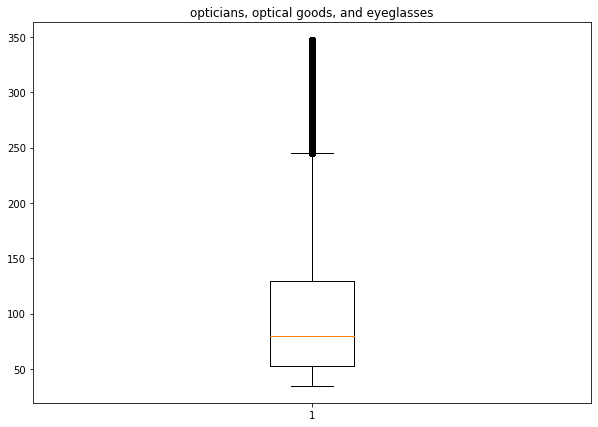

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


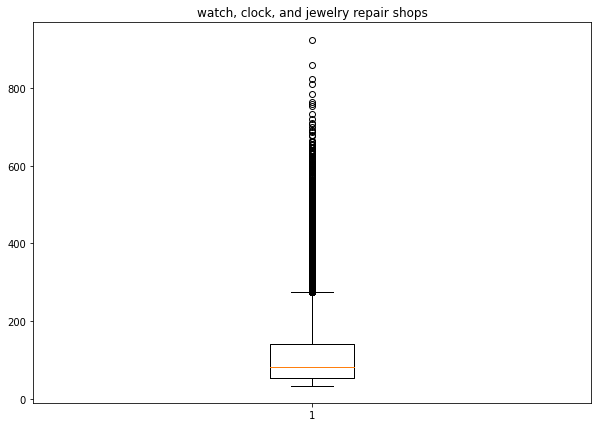

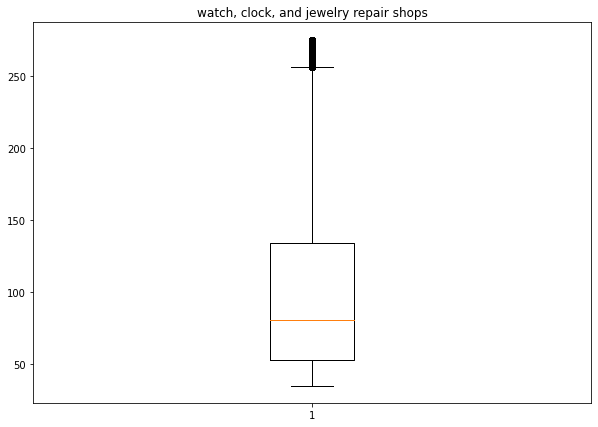

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


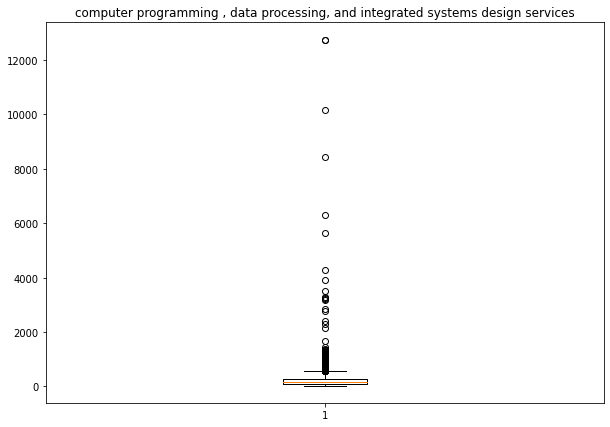

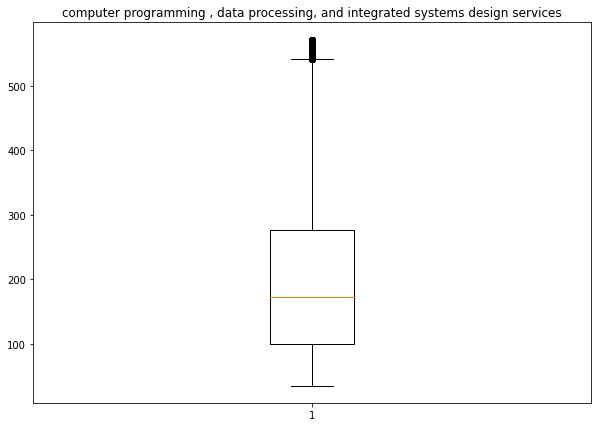

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


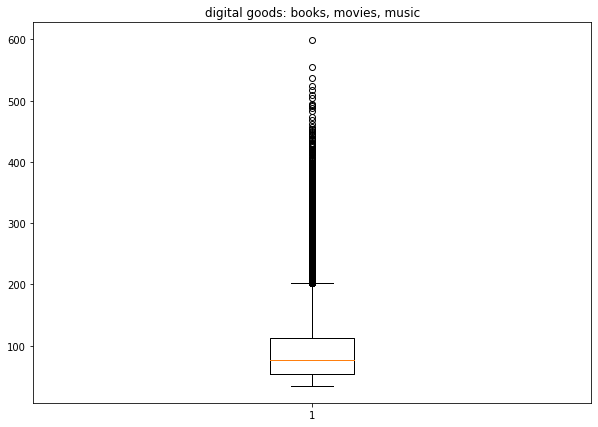

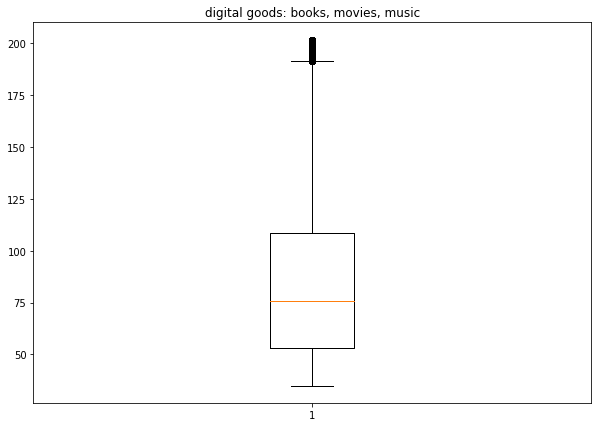

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


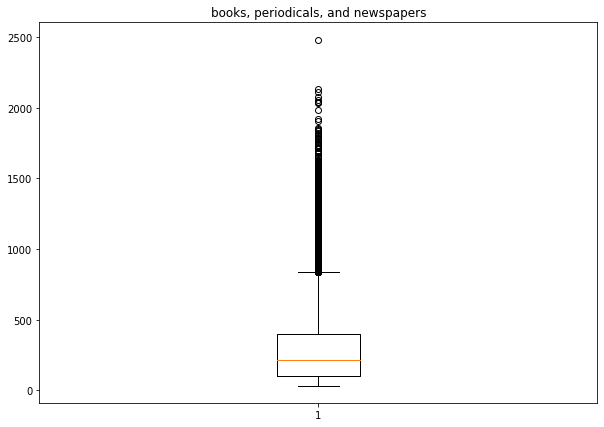

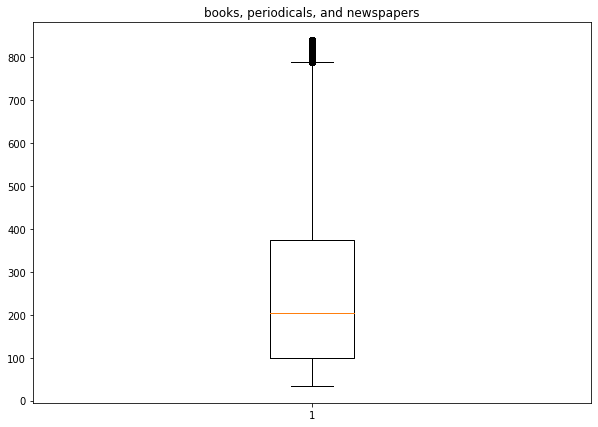

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


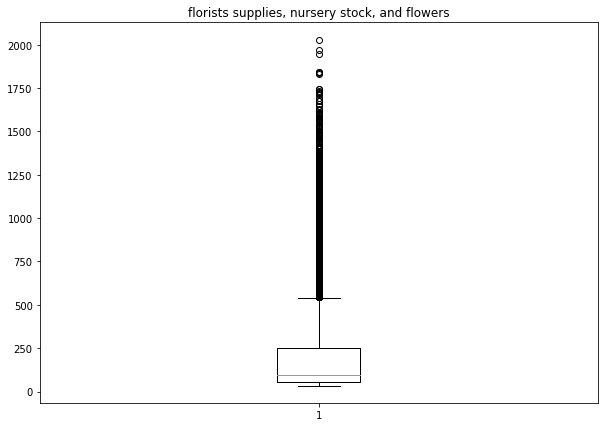

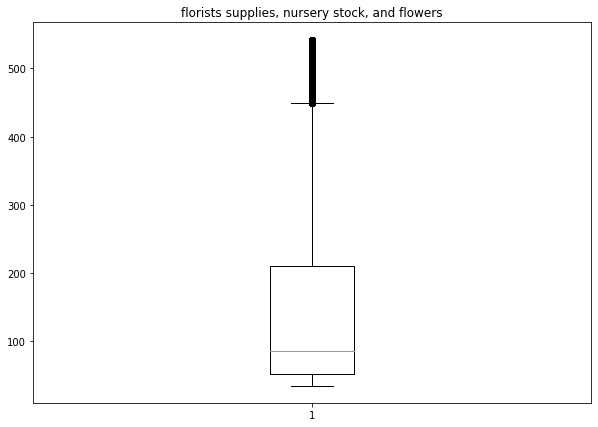

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


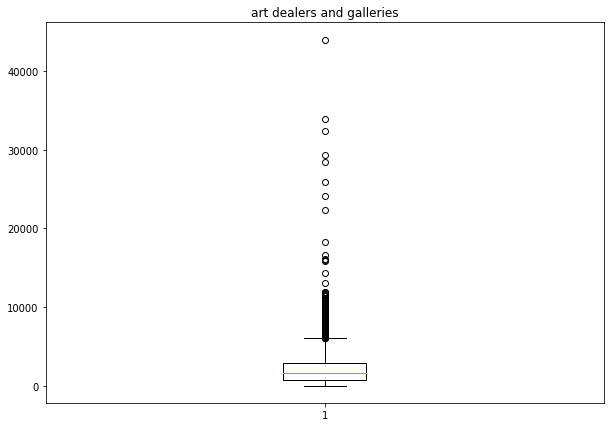

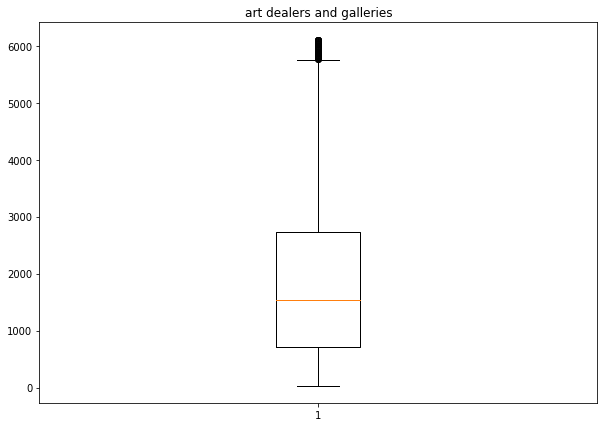

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


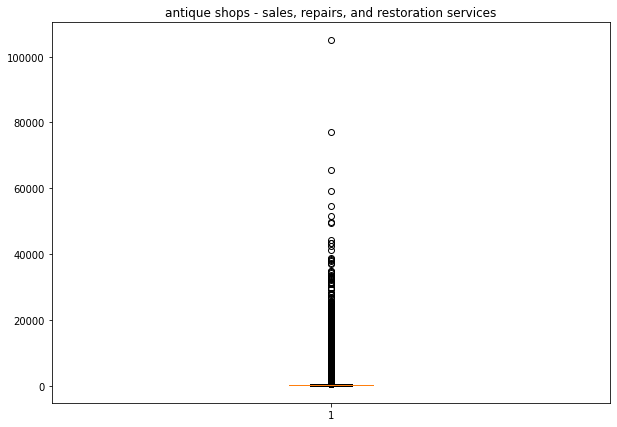

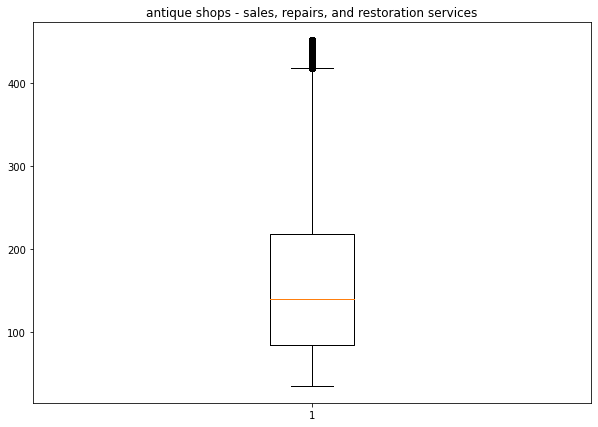

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


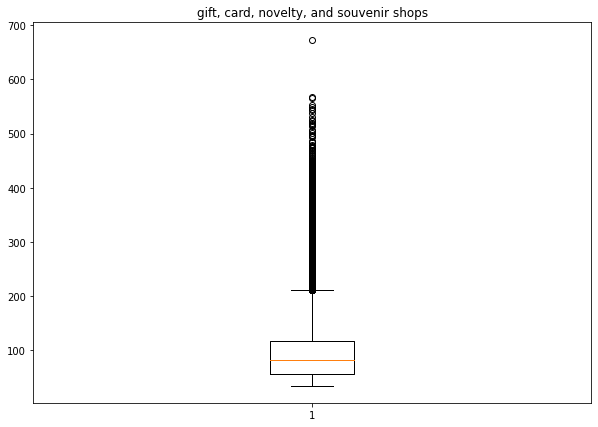

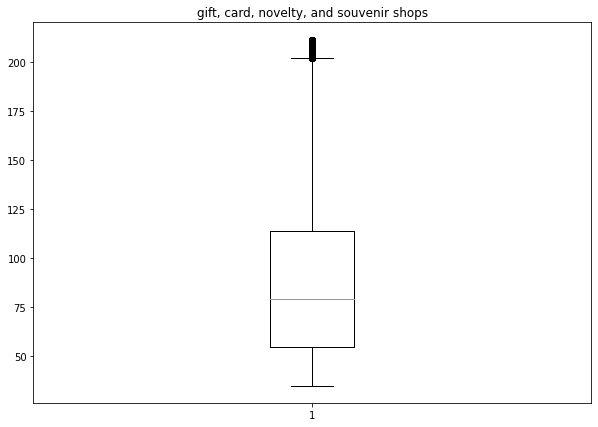

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


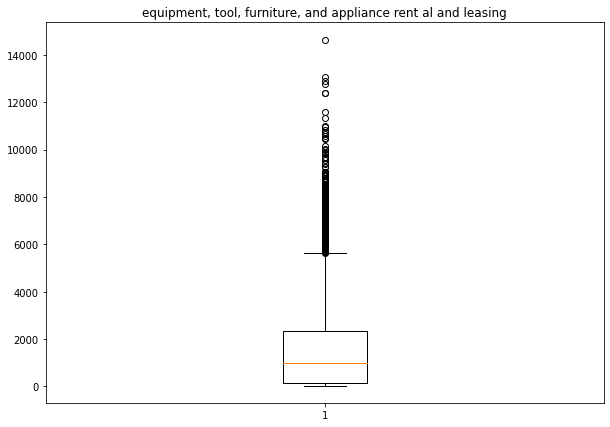

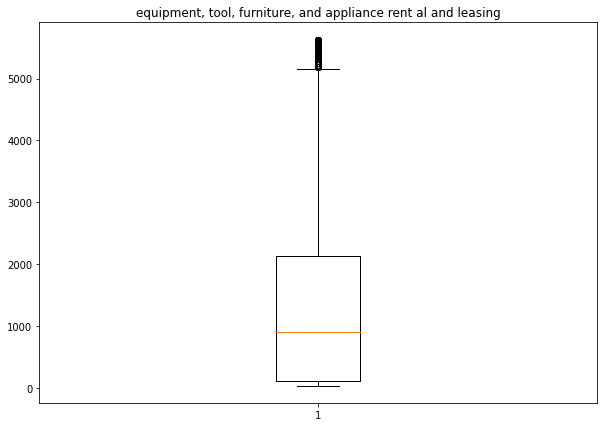

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


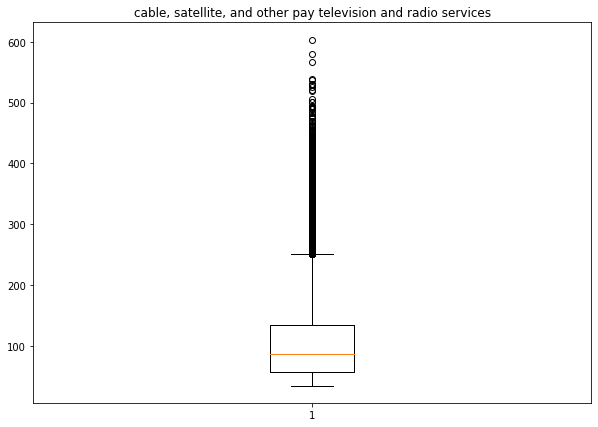

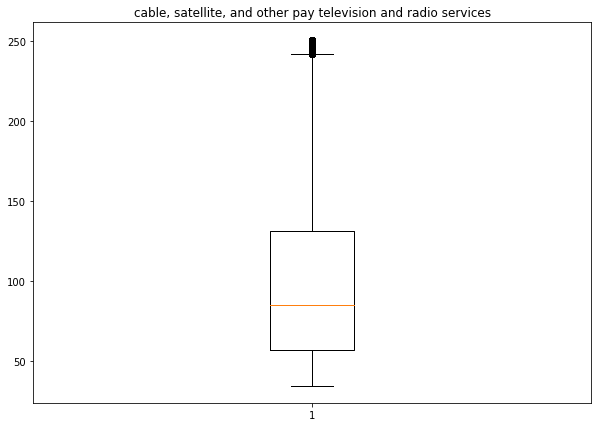

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


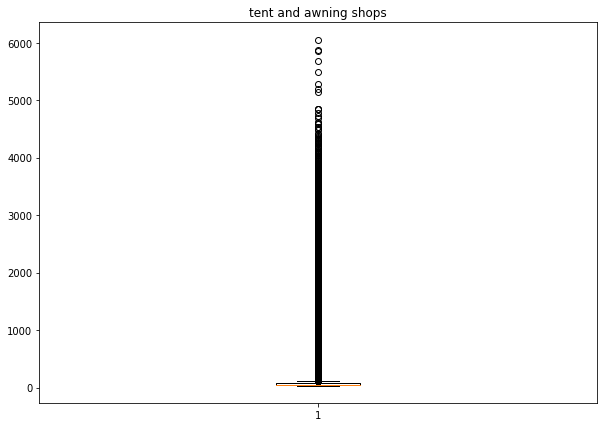

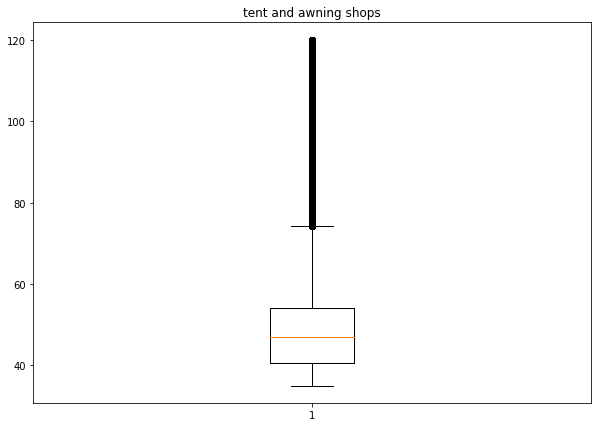

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


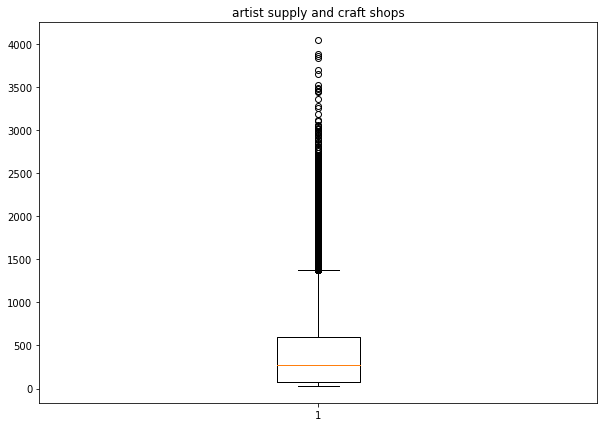

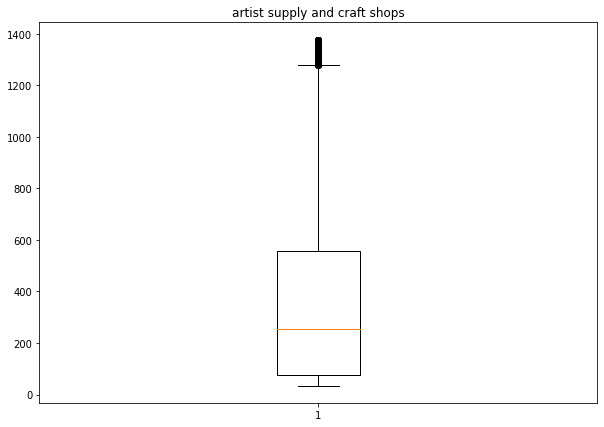

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


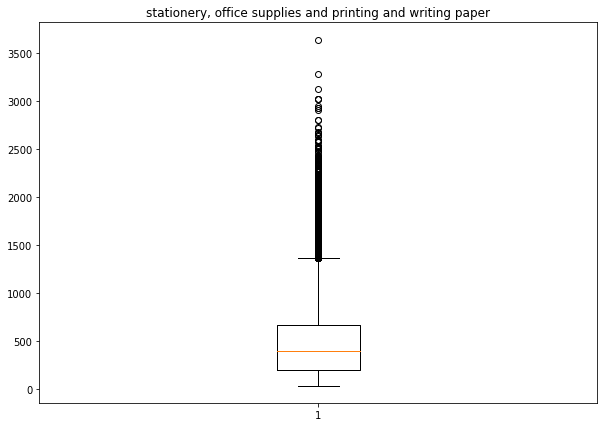

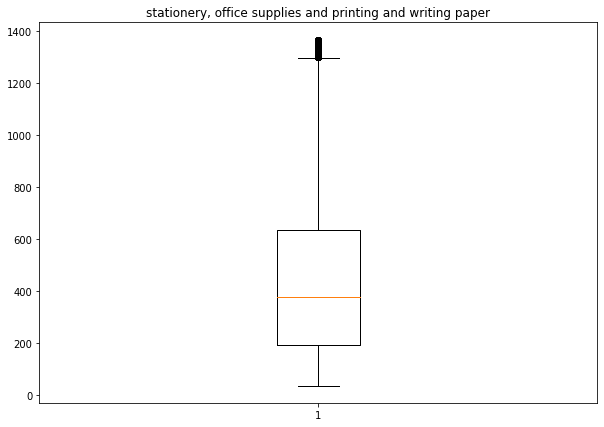

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


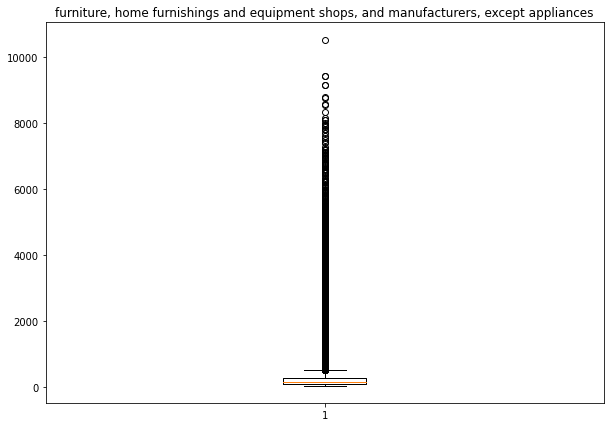

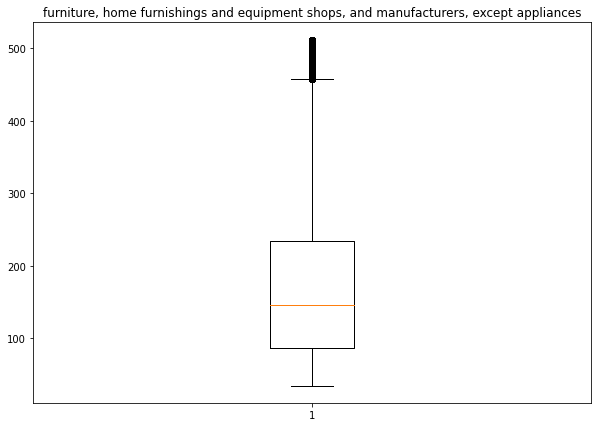

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


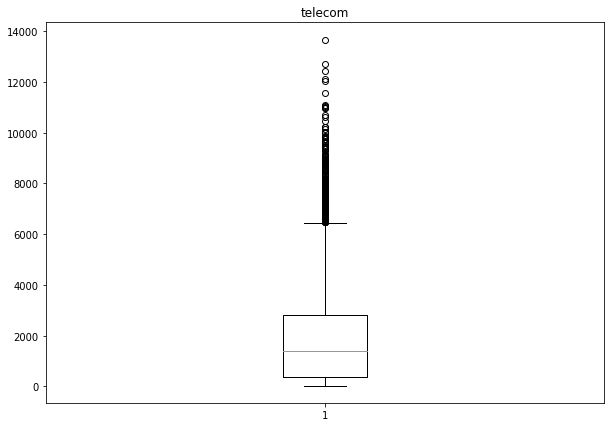

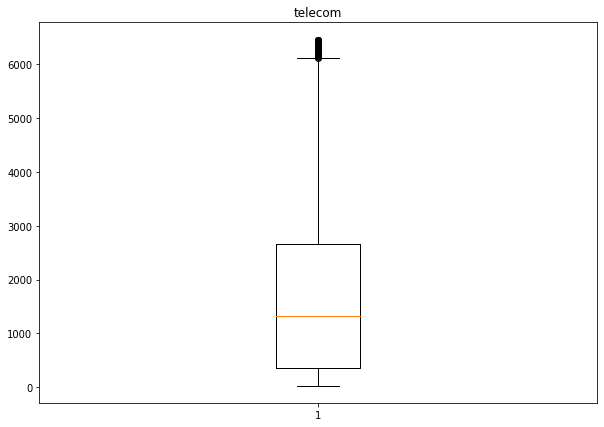

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


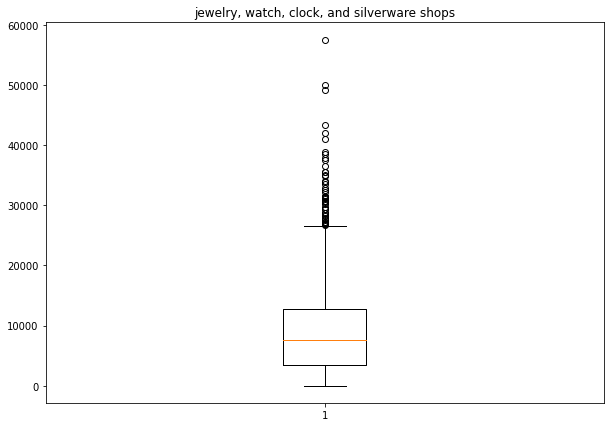

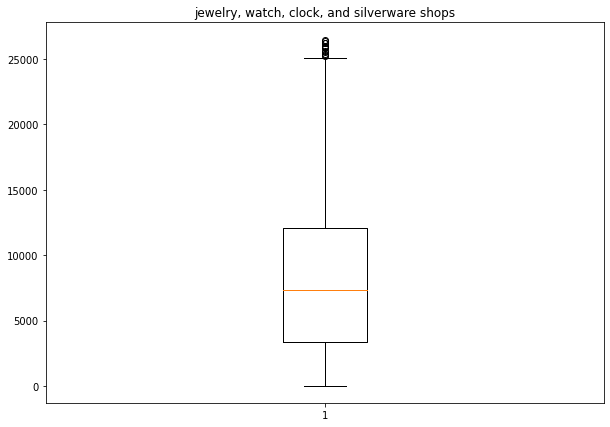

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


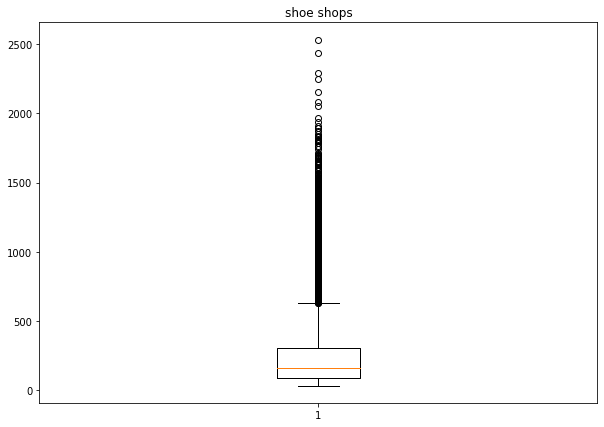

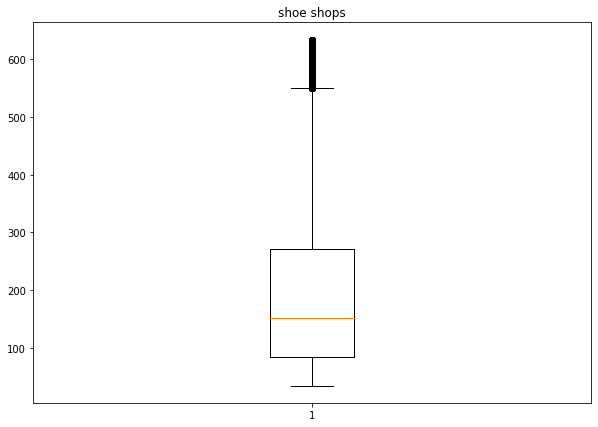

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


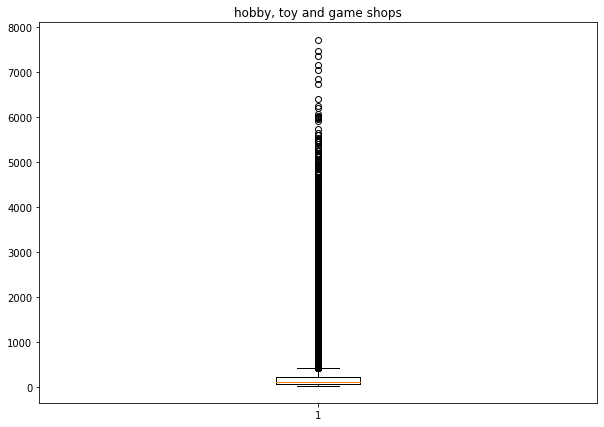

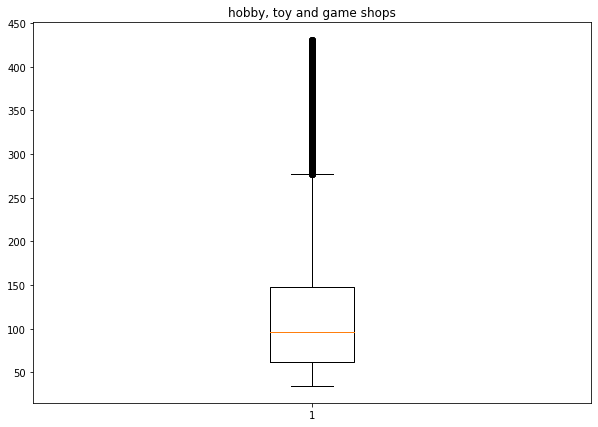

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


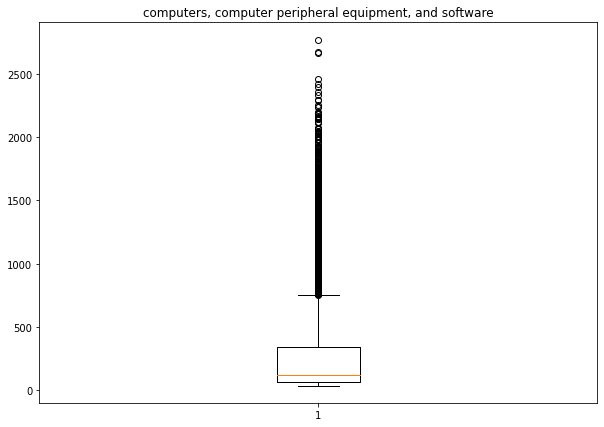

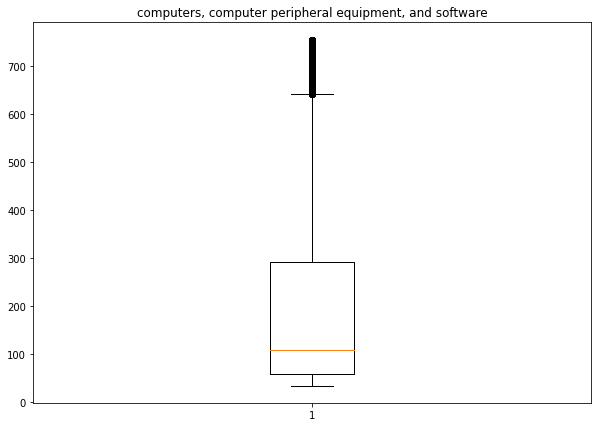

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


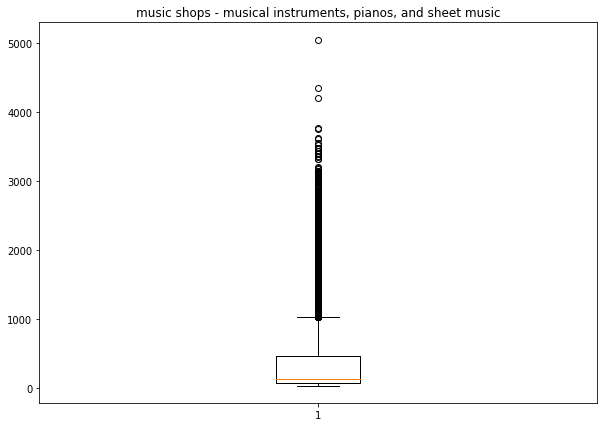

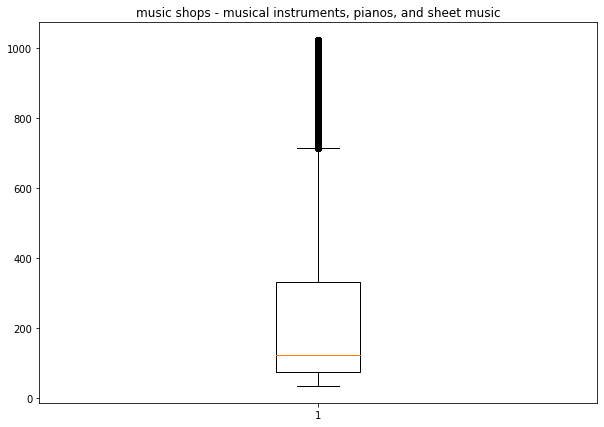

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


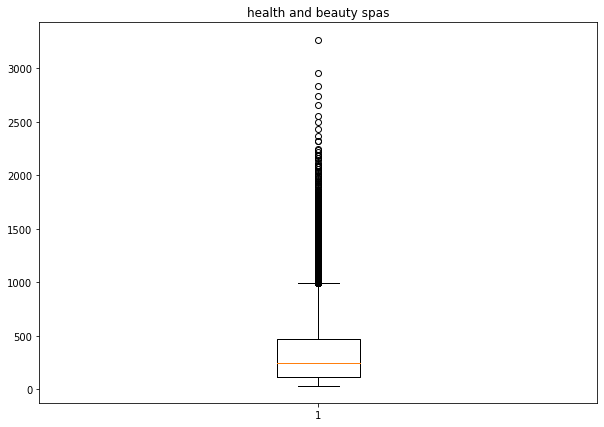

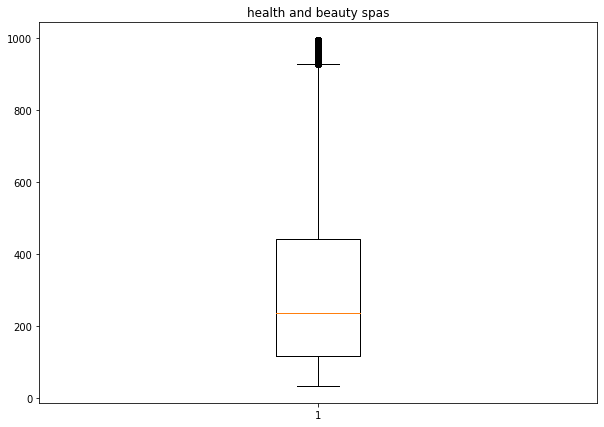

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


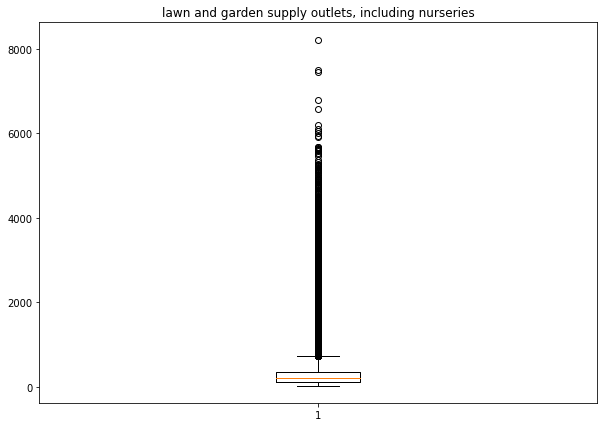

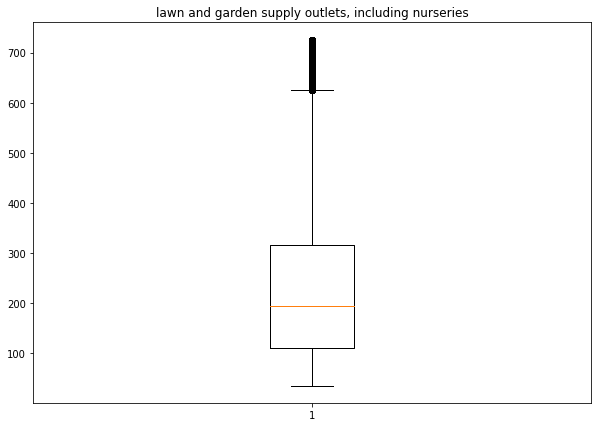

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


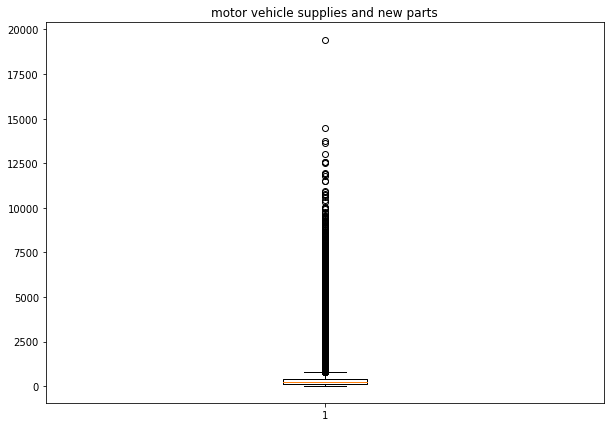

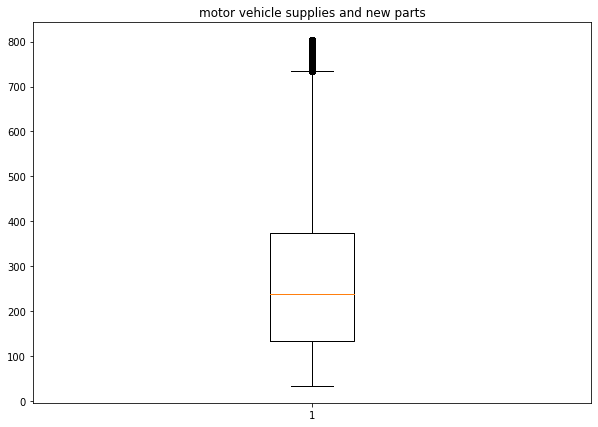

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


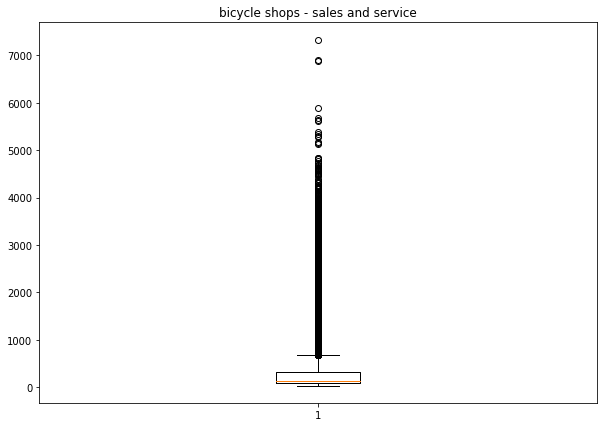

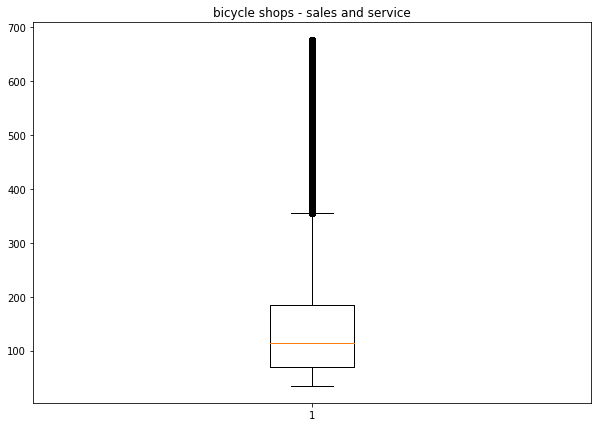

/var/folders/4x/9t5yd6t12x72d6x0qf9hyyrr0000gn/T/ipykernel_61841/3473466535.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe


In [27]:
df_outlier_removed_tags = remove_outlier_tags_IQR(df_trx)

In [28]:
df_outlier_removed_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2202521 entries, 0 to 48641
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   merchant_abn    int64  
 1   user_id         int64  
 2   consumer_id     object 
 3   consumer_name   object 
 4   address         object 
 5   state           object 
 6   postcode        object 
 7   gender          object 
 8   dollar_value    float64
 9   order_id        object 
 10  order_datetime  object 
 11  merchant_name   object 
 12  tags            object 
 13  categories      object 
 14  revenue_level   object 
 15  take_rate       float32
dtypes: float32(1), float64(1), int64(2), object(12)
memory usage: 277.3+ MB


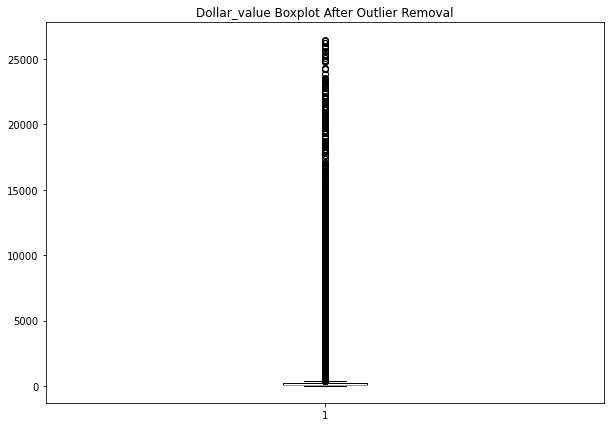

In [29]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df_outlier_removed_tags['dollar_value'])
plt.title("Dollar_value Boxplot After Outlier Removal")
plt.show()

Export final dataframe as a parquet.

In [30]:
df_outlier_removed.to_parquet('../data/curated/clean_outlier_all_df.parquet')
df_outlier_removed_tags.to_parquet('../data/curated/clean_outlier_tags_df.parquet')

---
### Miscellaneous

Text(0, 0.5, 'number of transactions')

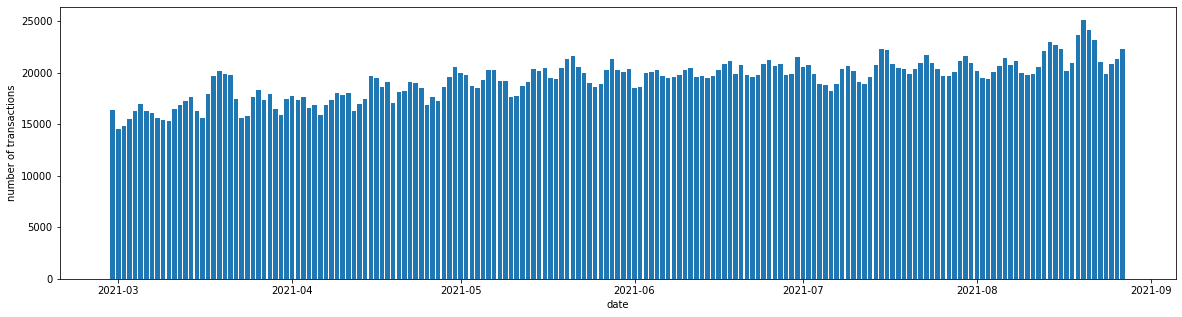

In [102]:
# number of transactions by day
daily_transaction_frequency = consumer_merchants.groupBy('order_datetime').count()
daily_tf = daily_transaction_frequency.toPandas()
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.bar(daily_tf['order_datetime'], daily_tf['count'])
plt.xlabel('date')
plt.ylabel('number of transactions')

Text(0, 0.5, 'number of transactions')

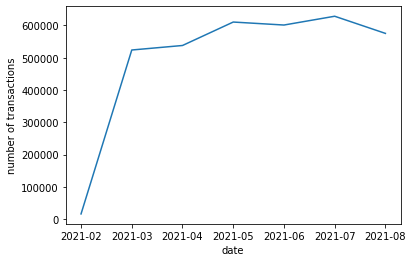

In [110]:
# number of transactions by month
monthly_transaction_frequency = consumer_merchants.select(F.date_format('order_datetime','yyyy-MM').alias('month')).groupby('month').count()
monthly_transaction_frequency = monthly_transaction_frequency.orderBy('month')
monthly_tf = monthly_transaction_frequency.toPandas()
plt.plot(monthly_tf['month'], monthly_tf['count'])
plt.xlabel('date')
plt.ylabel('number of transactions')

Text(0, 0.5, 'average dollar value')

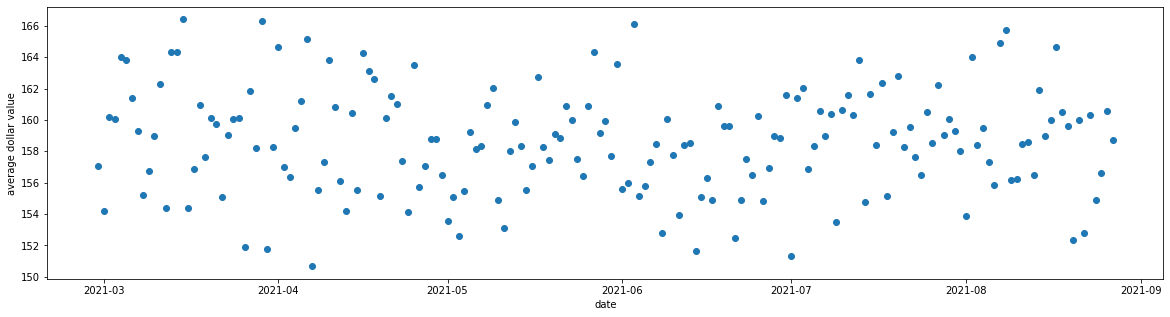

In [82]:
# average transaction value by day
daily_transaction_sum = consumer_merchants.groupBy('order_datetime').agg(avg('dollar_value').alias('average_dollar_value')).toPandas()
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.scatter(daily_transaction_sum['order_datetime'], daily_transaction_sum['average_dollar_value'])
plt.xlabel('date')
plt.ylabel('average dollar value')

Text(0, 0.5, 'average_dollar_value')

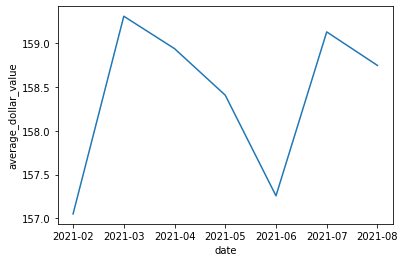

In [115]:
# average transactions value by month
monthly_transaction_sum = consumer_merchants.select(F.date_format('order_datetime','yyyy-MM').alias('month'), 'dollar_value').groupby('month').agg(avg('dollar_value').alias('average_dollar_value'))
monthly_transaction_sum = monthly_transaction_sum.orderBy('month')
monthly_ts = monthly_transaction_sum.toPandas()
plt.plot(monthly_ts['month'], monthly_ts['average_dollar_value'])
plt.xlabel('date')
plt.ylabel('average_dollar_value')

Text(0, 0.5, 'average value')

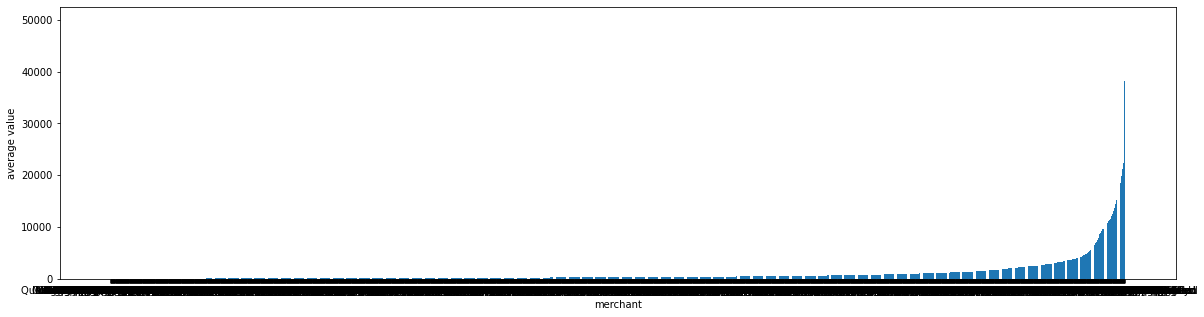

In [116]:
# average transaction value by merchant
merchant_transactions = consumer_merchants.groupBy('merchant_name').agg(avg('dollar_value').alias('average_value')).orderBy('average_value').toPandas()
fig = plt.figure()
fig.set_size_inches(20, 5)
plt.bar(merchant_transactions['merchant_name'], merchant_transactions['average_value'])
plt.xlabel('merchant')
plt.ylabel('average value')

In [83]:
merchant_transactions.filter(F.col('average_value') < 35).count()

127

In [126]:
# average transaction value by tags
tag_value = consumer_merchants.groupBy('tags').agg(avg('dollar_value').alias('average_value')).orderBy('average_value')
# fig = plt.figure()
# fig.set_size_inches(20, 5)
# plt.bar(tag_value['tags'], tag_value['average_value'])
# plt.xlabel('merchant')
# plt.ylabel('average value')

In [132]:
tag_value.count()

3910

In [131]:
tag_value.show(truncate=False)

# needs cleaning

+-------------------------------------------------------------------------+------------------+
|tags                                                                     |average_value     |
+-------------------------------------------------------------------------+------------------+
|[[gift, card, novelty, and souvenir shops], [c], [take rate: 2.26]]      |10.83996215945744 |
|[[digital goods: books, movies, music], [c], [take rate: 2.52]]          |11.39543110447357 |
|((tent and awning shops), (b), (take rate: 3.48))                        |12.594530282797015|
|[(tEnt and awning shops), (b), (take rate: 4.08)]                        |13.129463332505008|
|[(tent and  Awning shops), (a), (take rate: 5.96)]                       |13.496950987190855|
|[(tent and awning shops), (b), (take rate: 4.04)]                        |13.566331760261406|
|((tent and awning shops), (b), (take rate: 5.05))                        |13.766548143107327|
|[[tent and awning shops], [c], [take rate: 2.22]]

In [13]:
df = consumer_merchants.toPandas()

Text(0, 0.5, 'dollar_value')

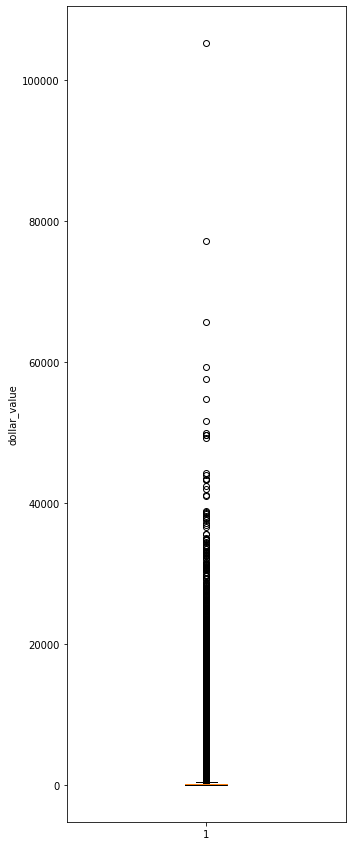

In [14]:
# y_axis = np.arange(100000)
fig = plt.figure()
fig.set_size_inches(5, 15)
plt.boxplot(df['dollar_value'])
plt.ylabel('dollar_value')
# plt.yticks(y_axis, step=10000)

Text(0, 0.5, 'dollar_value')

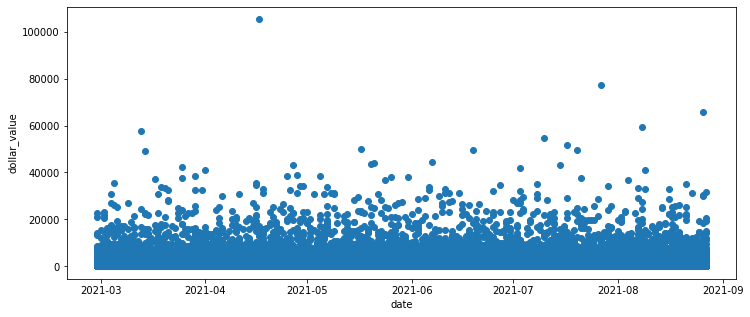

In [19]:
fig = plt.figure()
fig.set_size_inches(12, 5)
plt.scatter(df['order_datetime'], df['dollar_value'])
plt.xlabel('date')
plt.ylabel('dollar_value')

Text(0, 0.5, 'dollar_value')

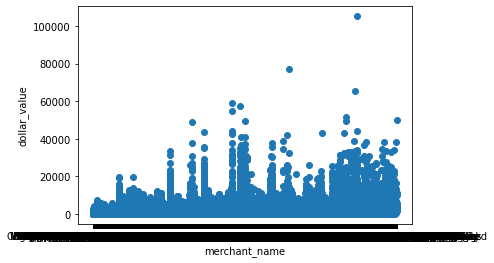

In [28]:
# fig = plt.figure()
# fig.set_size_inches(30, 5)
plt.scatter(df['merchant_name'], df['dollar_value'])
plt.xlabel('merchant_name')
plt.ylabel('dollar_value')

Text(0, 0.5, 'dollar_value')

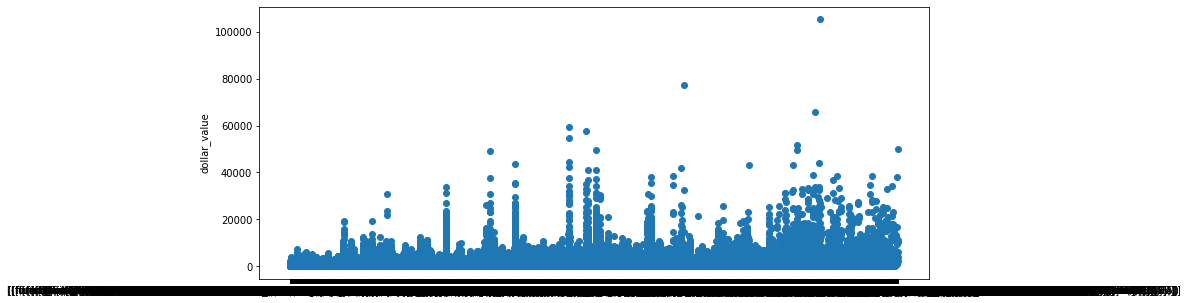

In [118]:
fig = plt.figure()
fig.set_size_inches(12, 5)
plt.scatter(df['tags'], df['dollar_value'])
# plt.xlabel('tags')
plt.ylabel('dollar_value')